This is a sentiment analysis using tweets regarding Apple. 

#Import Libraries

In [1]:
#import regular libraries for data cleaning, data visualization, and data exploration
import pandas as pd 
import numpy as np
import string
import nltk
import nltk.corpus
import sklearn
import re
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

#import Natural Language Toolkit 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# sklearn
#ML Models
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score

#To create a pipeline 
from sklearn.pipeline import Pipeline

nltk.download('wordnet')
nltk.download('omw-1.4') 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
#Could not read file, determine what the character encoding is to open file

import chardet
with open("/content/Apple-Twitter-Sentiment-DFE.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ISO-8859-1', 'confidence': 0.7295237651444547, 'language': ''}

In [3]:
#load file
df = pd.read_csv("/content/Apple-Twitter-Sentiment-DFE.csv", encoding='ISO-8859-1')

# EDA

In [4]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [5]:
#describe data
df.describe()

,_unit_id,_trusted_judgments,sentiment:confidence,id
count,3.886000e+03,3886.000000,3886.000000,3.886000e+03
mean,6.234975e+08,3.687082,0.829526,5.410039e+17
std,1.171906e+03,2.004595,0.175864,7.942752e+14
min,6.234955e+08,3.000000,0.332700,5.400000e+17
25%,6.234965e+08,3.000000,0.674475,5.400000e+17
50%,6.234975e+08,3.000000,0.811250,5.410000e+17
75%,6.234984e+08,3.000000,1.000000,5.420000e+17
max,6.235173e+08,27.000000,1.000000,5.420000e+17


In [6]:
#get shape
df.shape

(3886, 12)

In [7]:
#get data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


In [8]:
#check for missing values
df.isnull().sum()

_unit_id                   0
_golden                    0
_unit_state                0
_trusted_judgments         0
_last_judgment_at        103
sentiment                  0
sentiment:confidence       0
date                       0
id                         0
query                      0
sentiment_gold          3783
text                       0
dtype: int64

In [9]:
#check for duplicates
df.duplicated().sum()

0

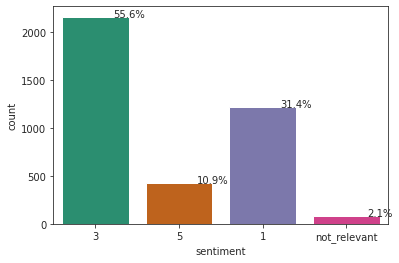

In [10]:
#check "sentiment" values

sns.set_style("ticks")
total = float(len(df))
ax = sns.countplot(x="sentiment", data=df, palette = "Dark2")
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

This is a look into the sentiment around Apple computers based on tweets containing #AAPL, @apple, etc.

Tweets can be positive, neutral or negative.

The task is to identify whether the tweet about Apple is positive, neutral or negative. (If the tweet isn't about Apple, let's assume the identification is neutral or not relevant).

The sentiment values we have:

1) Positive - 5;

2) Neutral - 3;

3) Negative - 1;

4) Not Relevant - not_relevant.

In [11]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [12]:
from datetime import datetime

def clean_date(d):
  return datetime.strptime(d, '%a %b %d %H:%M:%S +%f %Y').strftime('%Y-%m-%d')

In [13]:
df['clean_date'] = df['date'].apply(clean_date)

In [14]:
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text,clean_date
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...,2014-12-01
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,2014-12-01
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...,2014-12-01
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...,2014-12-01
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL,2014-12-01


In [15]:
df['clean_date'].value_counts()

2014-12-04    703
2014-12-09    622
2014-12-02    529
2014-12-05    524
2014-12-03    499
2014-12-08    465
2014-12-06    296
2014-12-07    223
2014-12-01     24
2014-12-10      1
Name: clean_date, dtype: int64

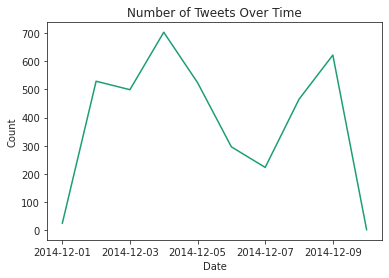

In [16]:
df.groupby(['clean_date'])['_unit_id'].count().plot(cmap="Dark2",
                                                    title = "Number of Tweets Over Time",
                                                    xlabel = "Date",
                                                    ylabel = "Count")
plt.show()

In [17]:
df.groupby(['clean_date','sentiment'])['_unit_id'].count()

clean_date  sentiment   
2014-12-01  1                 4
            3                15
            5                 3
            not_relevant      2
2014-12-02  1               168
            3               295
            5                52
            not_relevant     14
2014-12-03  1               172
            3               263
            5                51
            not_relevant     13
2014-12-04  1               195
            3               420
            5                78
            not_relevant     10
2014-12-05  1               148
            3               309
            5                55
            not_relevant     12
2014-12-06  1               137
            3               123
            5                30
            not_relevant      6
2014-12-07  1                92
            3                98
            5                27
            not_relevant      6
2014-12-08  1               158
            3               236
            5  

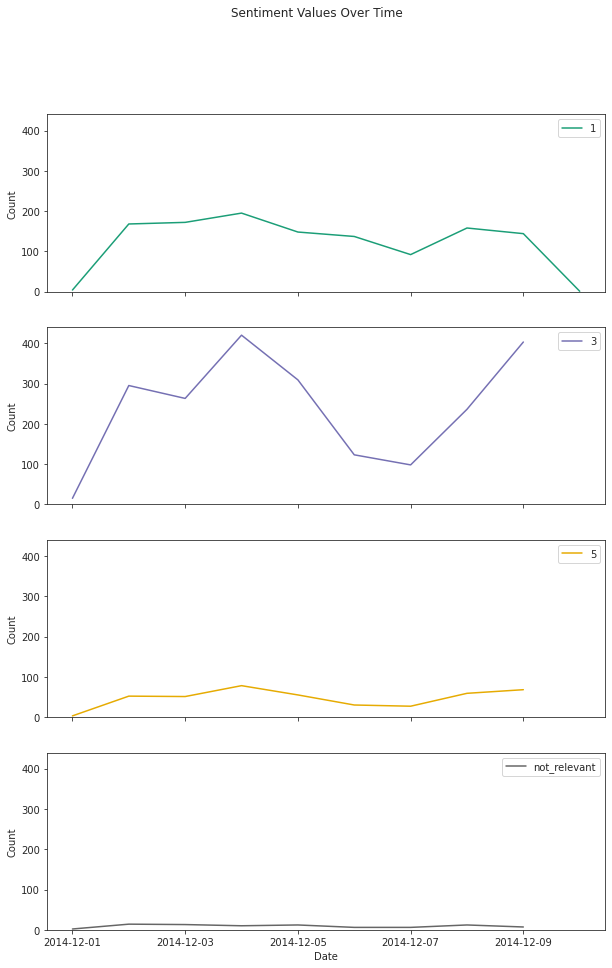

In [18]:
#visualize values over time
pd.pivot_table(df.reset_index(),
               index='clean_date', 
               columns='sentiment', 
               values = '_unit_id',
               aggfunc = 'count').plot(subplots=True, 
                                       figsize = (10,15), 
                                       ylim = (0,440),
                                       colormap = "Dark2",
                                       title = "Sentiment Values Over Time",
                                       xlabel = "Date",
                                       ylabel = "Count")
plt.show()

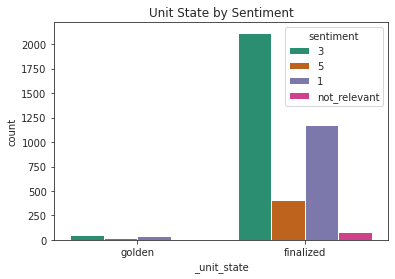

In [19]:
sns.countplot(x="_unit_state", hue = "sentiment", data=df, palette = "Dark2")
plt.title("Unit State by Sentiment")
plt.show()

#Data Cleaning For Models

In [20]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'sentiment', 'sentiment:confidence', 'date', 'id',
       'query', 'sentiment_gold', 'text', 'clean_date'],
      dtype='object')

In [21]:
#Drop not not needed columns
df_subset = df[['text','sentiment']]

In [22]:
df_subset.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3


In [23]:
df_subset.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3


In [24]:
df_subset['sentiment'].unique()

array(['3', '5', '1', 'not_relevant'], dtype=object)

In [25]:
#drop row entries that contain "not_relevant"
df_subset = df_subset[df_subset['sentiment'] != "not_relevant"]
df_subset['sentiment'].unique()

array(['3', '5', '1'], dtype=object)

In [26]:
df_subset.shape

(3804, 2)

1) Positive - 5; Convert to 2

2) Neutral - 3; Convert to 1

3) Negative - 1; Convert to 0

In [27]:
#replace values to ease understanding
value_dict = {"1":0,"3":1,"5":2}
df_subset["sentiment"] = df_subset["sentiment"].map(value_dict)
df_subset.head()

<ipython-input-27-3aca3d3fdbb6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["sentiment"] = df_subset["sentiment"].map(value_dict)


,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,1
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,1
2,My cat only chews @apple cords. Such an #Apple...,1
3,I agree with @jimcramer that the #IndividualIn...,1
4,Nobody expects the Spanish Inquisition #AAPL,1


In [28]:
df_subset['sentiment'].unique()

array([1, 2, 0])

In [29]:
df_subset['sentiment'].dtype

dtype('int64')

In [30]:
df_subset.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,1
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,1
2,My cat only chews @apple cords. Such an #Apple...,1
3,I agree with @jimcramer that the #IndividualIn...,1
4,Nobody expects the Spanish Inquisition #AAPL,1


In [31]:
# Storing data in lists.
text, sentiment = list(df_subset['text']), list(df_subset['sentiment'])

In [32]:
# emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [33]:
#list of stop words
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meanings to one word. 
Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as the same. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

Applications of lemmatization are: 
- Used in comprehensive retrieval systems like search engines.
- Used in compact indexing

Examples:
- better: good
- rocks: rock  

https://www.geeksforgeeks.org/python-lemmatization-with-nltk/ 

In [34]:
lemmatizer = WordNetLemmatizer()

def preprocess(textdata):
    processed_texts = []

    # Defining regex patterns.
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern = '@[^\s]+'
    alpha_pattern = "[^a-zA-Z0-9]"
    sequence_pattern = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        tweet = re.sub(url_pattern, ' URL', tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
            # Replace @USERNAME to 'USER'.
        tweet = re.sub(user_pattern, ' USER', tweet)
        # Replace all non alphabets.
        tweet = re.sub(alpha_pattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)

        preprocessed_words = []
        for word in tweet.split():
            # Check if the word is a stopword.
            if len(word) > 1 and word not in stopwords:
                # Lemmatizing the word.
                word = lemmatizer.lemmatize(word)
                preprocessed_words.append(word)

        processed_texts.append(' '.join(preprocessed_words))

    return processed_texts

In [35]:
processedtext = preprocess(text)

In [36]:
processedtext

['aapl 10 best steve job email ever URL',
 'rt USER aapl stock mini flash crash today aapl aapl URL',
 'cat chew USER cord applesnob',
 'agree USER individualinvestor not trade apple aapl extended today pullback good see',
 'nobody expects spanish inquisition aapl',
 'aapl rocket stock buy december gain apple URL',
 'top USER tablet damn right URL',
 'cnbctv apple margin better expected aapl URL',
 'apple inc flash crash need know URL aapl',
 'aapl presentation show make world biggest tech company URL',
 'wtf battery 31 one second ago 29 wtf USER',
 'apple watch top search engine list best wearable tech URL aapl iwatch applewatch',
 'best designed iphone apps world according USER URL URL',
 'rt USER bought USER USER store pretty good logo match wait install URL',
 'USER contact sync yosemite ios8 seriously screwed used much stable past icloud isync',
 'aapl USER thanks non factual dumb twitter follower stock drop point one minute thanks dummy rumor',
 'warning buy iphone 5 unlocked USE

In [37]:
words_values = pd.Series(" ".join(processedtext).split()).value_counts()
print(words_values)
rare_words = words_values[words_values <= 3]
print(rare_words)

USER         5247
URL          2263
aapl         1320
apple        1104
rt            843
             ... 
pleasee         1
keepp           1
flyingg         1
lmaoo           1
unhelpful       1
Length: 5146, dtype: int64
spared       3
surprise     3
campus       3
community    3
wasted       3
            ..
pleasee      1
keepp        1
flyingg      1
lmaoo        1
unhelpful    1
Length: 3789, dtype: int64


#Test, Train, Split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.20, random_state = 0)

Tf-idf Vectorizer

TF-IDF stands for term frequency and inverse document frequency. It is used to tokenize the documents learn the vocabulary and inverse the document frequency weightings, and allow to encode new documents.

Example:
- A vocabulary of 8 words is learned from the given documents and each word is assigned a unique integer index in the output vector.

TF-IDF will transform the text into meaningful representation of numbers which is used to fit machine learning algorithm for predictions.

TF-IDF Vectorizer is a measure of originality of a word by comparing the number of times a word appears in document with the number of documents the word appears in. 

The TfidfVectorizer converts a collection of raw documents into a matrix of TF-IDF features.

Formula:
- TF-IDF = TF(t, d) x IDF(t), where, TF(t, d) = Number of times term "t" appears in a document "d". IDF(t) = Inverse document frequency of the term t.



https://www.projectpro.io/recipes/use-tf-df-vectorizer 

In [39]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features = 500000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [40]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

#Machine Learning Models

1. Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation. (https://scikit-learn.org/stable/modules/tree.html#tree) 
  - A Decision Tree is a type of model used for both classification and regression. Decision trees answer sequential questions which sends us down a certain route of the tree given the answer. Essentially, the model behaves with "if this then that" conditions ultimately leading to a specific result.

2. Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection. The advantages of support vector machines are: Effective in high dimensional spaces, still effective in cases where number of dimensions is greater than the number of samples, and uses a subset of training points in the decision function (called support vectors), so it is also memory efficient. (https://scikit-learn.org/stable/modules/svm.html)
  - SVC, NuSVC and LinearSVC are classes capable of performing binary and multi-class classification on a dataset.

3. A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree. (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) 
  - Random forest consists of multiple random decision trees. Where each tree is built on a random sample from the original data. And then at each tree node, a subset of features are randomly selected to generate the best possible split.  


In [41]:
DTmodel = DecisionTreeClassifier()
SVCmodel = LinearSVC()
RFmodel = RandomForestClassifier()

In [42]:
models = [DTmodel, SVCmodel, RFmodel]
for model in models:
    model.fit(X_train, y_train)
    print(f'{model} is trained!')

DecisionTreeClassifier() is trained!
LinearSVC() is trained!
RandomForestClassifier() is trained!


In [43]:
def model_evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

In [44]:
for model in models:
  print(model, model_evaluate(model))

              precision    recall  f1-score   support

           0       0.69      0.56      0.62       248
           1       0.72      0.83      0.77       431
           2       0.38      0.29      0.33        82

    accuracy                           0.68       761
   macro avg       0.60      0.56      0.57       761
weighted avg       0.67      0.68      0.67       761

DecisionTreeClassifier() None
              precision    recall  f1-score   support

           0       0.83      0.69      0.75       248
           1       0.75      0.90      0.82       431
           2       0.59      0.28      0.38        82

    accuracy                           0.76       761
   macro avg       0.72      0.62      0.65       761
weighted avg       0.76      0.76      0.75       761

LinearSVC() None
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       248
           1       0.73      0.94      0.82       431
           2       0.53     

###Create Pipeline 

A machine learning pipeline is a way to codify and automate the workflow it takes to produce a machine learning model. Machine learning pipelines consist of multiple sequential steps that do everything from data extraction and preprocessing to model training and deployment.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size = 0.05, random_state = 0)

In [46]:
dt_pipe = Pipeline([('vectorizer', vectorizer), ('dt', DTmodel)])
dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('dt', DecisionTreeClassifier())])

In [47]:
svc_pipe = Pipeline([('vectorizer', vectorizer), ('svc', SVCmodel)])
svc_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('svc', LinearSVC())])

In [48]:
rf_pipe = Pipeline([('vectorizer', vectorizer), ('rf', RFmodel)])
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('rf', RandomForestClassifier())])

In [49]:
pipes = [dt_pipe, svc_pipe, rf_pipe]

for pipe in pipes:
  print(pipe, model_evaluate(pipe))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67        51
           1       0.76      0.88      0.82       117
           2       0.64      0.30      0.41        23

    accuracy                           0.74       191
   macro avg       0.70      0.60      0.63       191
weighted avg       0.73      0.74      0.73       191

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('dt', DecisionTreeClassifier())]) None
              precision    recall  f1-score   support

           0       0.82      0.65      0.73        51
           1       0.77      0.90      0.83       117
           2       0.40      0.26      0.32        23

    accuracy                           0.75       191
   macro avg       0.67      0.60      0.62       191
weighted avg       0.74      0.75      0.74       191

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_feature

In [50]:
with open('/content/drive/MyDrive/Predictive Analytics/Final Project/dt_pipe.pickle', 'wb') as file:
    pickle.dump(dt_pipe, file) 

In [51]:
with open('/content/drive/MyDrive/Predictive Analytics/Final Project/svc_pipe.pickle', 'wb') as file:
    pickle.dump(svc_pipe, file) 

In [52]:
with open('/content/drive/MyDrive/Predictive Analytics/Final Project/rf_pipe.pickle', 'wb') as file:
    pickle.dump(rf_pipe, file) 

In [53]:
with open('/content/drive/MyDrive/Predictive Analytics/Final Project/dt_pipe.pickle', 'rb') as file:
    loaded_dt_pipe = pickle.load(file)

In [54]:
with open('/content/drive/MyDrive/Predictive Analytics/Final Project/svc_pipe.pickle', 'rb') as file:
    loaded_svc_pipe = pickle.load(file)

In [55]:
with open('/content/drive/MyDrive/Predictive Analytics/Final Project/rf_pipe.pickle', 'rb') as file:
    loaded_rf_pipe = pickle.load(file)

In [56]:
loaded_pipes = [loaded_dt_pipe, loaded_svc_pipe, loaded_rf_pipe]

for pipe in loaded_pipes:
  print(pipe, model_evaluate(pipe))

              precision    recall  f1-score   support

           0       0.71      0.63      0.67        51
           1       0.76      0.88      0.82       117
           2       0.64      0.30      0.41        23

    accuracy                           0.74       191
   macro avg       0.70      0.60      0.63       191
weighted avg       0.73      0.74      0.73       191

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('dt', DecisionTreeClassifier())]) None
              precision    recall  f1-score   support

           0       0.82      0.65      0.73        51
           1       0.77      0.90      0.83       117
           2       0.40      0.26      0.32        23

    accuracy                           0.75       191
   macro avg       0.67      0.60      0.62       191
weighted avg       0.74      0.75      0.74       191

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_feature

#Test models

In [57]:
def predict(model, text):
    # Predict the sentiment
    preprocessed_text = preprocess(text)
    predictions = model.predict(preprocessed_text)

    pred_to_label = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

    # Make a list of text with sentiment.
    data = []
    for t, pred in zip(text, predictions):
        data.append((t, pred, pred_to_label[pred]))

    return data

In [58]:
sample_text = ["Apple sucks! Nothing works correctly."]

In [59]:
for pipe in loaded_pipes:
  predictions = predict(pipe, sample_text)
  print(pipe, predictions)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('dt', DecisionTreeClassifier())]) [('Apple sucks! Nothing works correctly.', 0, 'Negative')]
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('svc', LinearSVC())]) [('Apple sucks! Nothing works correctly.', 0, 'Negative')]
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('rf', RandomForestClassifier())]) [('Apple sucks! Nothing works correctly.', 0, 'Negative')]


In [64]:
sample_text2 = ['Apple products are the best!']

In [65]:
for pipe in loaded_pipes:
  predictions = predict(pipe, sample_text2)
  print(pipe, predictions)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('dt', DecisionTreeClassifier())]) [('Apple products are the best!', 2, 'Positive')]
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('svc', LinearSVC())]) [('Apple products are the best!', 2, 'Positive')]
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('rf', RandomForestClassifier())]) [('Apple products are the best!', 1, 'Neutral')]


In [60]:
hard = ["Apple is great! But would not recommend to anyone."]

In [61]:
for pipe in loaded_pipes:
  predictions = predict(pipe, hard)
  print(pipe, predictions)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('dt', DecisionTreeClassifier())]) [('Apple is great! But would not recommend to anyone.', 0, 'Negative')]
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('svc', LinearSVC())]) [('Apple is great! But would not recommend to anyone.', 0, 'Negative')]
Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('rf', RandomForestClassifier())]) [('Apple is great! But would not recommend to anyone.', 0, 'Negative')]
